# B-splines FEM solver for Poisson equation


## 1-D Poisson solver

Let's first define the assembly procedures for the stiffness matrix and the rhs.

In [1]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like, asarray
from matplotlib.pyplot import plot, show
%matplotlib inline

In [9]:
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffness(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]        
            # evaluation dependant uniquement de l'element
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):                
                    for jl_1 in range(0, p1+1):
                        for jl_2 in range(0, p2+1):
                            i1 = i_span_1 - p1 + il_1
                            j1 = i_span_1 - p1 + jl_1

                            i2 = i_span_2 - p2 + il_2
                            j2 = i_span_2 - p2 + jl_2

                            v = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]

                                    bj_0 = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_x = basis_1[ie1, jl_1, 1, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_y = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 1, g2]

                                    wvol = weights_1[ie1, g1] * weights_2[ie2, g2]

                                    v += (bi_x * bj_x + bi_y * bj_y) * wvol

                            matrix[i1, j1, i2, j2]  += v
    # ...

    return matrix    
# ...

In [15]:
# ... Assembly procedure for the rhs
def assemble_rhs(f, nelements, degree, spans, basis, weights, points, rhs):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...
    
    arr_f = zeros((k1,k2))
    arr_s = zeros((k1,k2))

    # ... build rhs
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]        
            # evaluation dependant uniquement de l'element
            for g1 in range(0, k1):
                for g2 in range(0, k2):
                    x1    = points_1[ie1, g1]
                    x2    = points_2[ie2, g2]
                    
                    arr_f[g1,g2] = f(x1,x2)
                    
            for g1 in range(0, k1):
                for g2 in range(0, k2):
                    arr_s[g1,g2] = 0.
                    for il_1 in range(0, p1+1):
                        for il_2 in range(0, p2+1):   
                            i1 = i_span_1 - p1 + il_1
                            i2 = i_span_2 - p2 + il_2   
                            
                            bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]                            
                            
                            arr_s[g1,g2] += s[i1,i2] * bi_0
                    
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):   
                    i1 = i_span_1 - p1 + il_1
                    i2 = i_span_2 - p2 + il_2                    

                    v = 0.0
                    for g1 in range(0, k1):
                        for g2 in range(0, k2):
                            bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]
                            
                            x1    = points_1[ie1, g1]
                            x2    = points_2[ie2, g2]
                            wvol  = weights_1[ie1, g1]*weights_2[ie2, g2]

                            v += bi_0 * arr_f[g1,g2] * arr_s[g1,g2] * wvol

                    rhs[i1,i2] += v
    # ...

    # ...
    return rhs
    # ...
# ...

---
**Note**: 
We added the function **f** as an argument of the *assemble_rhs* function. In general, we will avoid calling a function over the quadrature points for performance reasons. 

---

We will need the following imports from the **bsplines.py** file and the quadrature rule.

In [4]:
# nedded imports
from bsplines    import elements_spans  # computes the span for each element
from bsplines    import make_knots      # create a knot sequence from a grid
from bsplines    import quadrature_grid # create a quadrature rule over the whole 1d grid
from bsplines    import basis_ders_on_quad_grid # evaluates all bsplines and their derivatives on the quad grid
from quadratures import gauss_legendre
from utilities   import plot_field_1d # plot a solution for 1d problems

Now, let's create a B-spline Finite Element Space $V$ over a grid of $32$ elements, and using **cubic** *B-splines*.

A B-Spline space is defined here through a grid, we then call the function **make_knots** to create an open knot sequence. We finally, compute the spans for every element, to avoid doing it for each quadrature point on the current element, in the assembly procedure.

In [5]:
p  = 3    # spline degree
ne = 32   # number of elements

grid  = linspace(0., 1., ne+1)
knots = make_knots(grid, p, periodic=False)
spans = elements_spans(knots, p)  

In [6]:
nelements = len(grid) - 1
nbasis    = len(knots) - p - 1

# we need the value a B-Spline and its first derivative
nderiv = 1

# create the gauss-legendre rule, on [-1, 1]
u, w = gauss_legendre( p )

# for each element on the grid, we create a local quadrature grid
points, weights = quadrature_grid( grid, u, w )

# for each element and a quadrature points, 
# we compute the non-vanishing B-Splines
basis = basis_ders_on_quad_grid( knots, p, points, nderiv )

Assembling the **Stiffness** matrix is then done using

In [10]:
stiffness = zeros((nbasis, nbasis, nbasis, nbasis))
stiffness = assemble_stiffness((nelements, nelements), (p,p), (spans, spans), (basis, basis), (weights, weights), (points, points), matrix=stiffness)

### Analytical solution

In finite elements, one of the first tests we do is to check polynomial solutions of with a degree that smaller or equal to the one we chose for our discretization.
Here, we take the analytical solution $u(x) = x(1-x)$ which leads to the rhs $f(x) = - \partial_{xx} u(x) = 2$.

In [16]:
f = lambda x,y: 2.    
rhs = zeros((nbasis, nbasis))
rhs = assemble_rhs(f, (nelements, nelements), (p,p), (spans,spans), (basis,basis), (weights,weights), (points,points), rhs=rhs)

In order to apply the homogeneous Dirichlet boundary conditions, we only have to remove the first and the last splines, since their values at the boundary is $1$. Due to the partition of unity, the remaining splines are $0$ on the boundary.

In [9]:
# apply homogeneous dirichlet boundary conditions
rhs = rhs[1:-1,1:-1]
stiffness = stiffness[1:-1, 1:-1, 1:-1, 1:-1]

We use a **cg** solver from **scipy** to solve the linear system.

In [10]:
from scipy.sparse.linalg import cg
u, info = cg( stiffness, rhs, tol=1e-6, maxiter=5000 )

Now, we need to add the first and last control points, which are equal to **0**, then proceed to the plot.

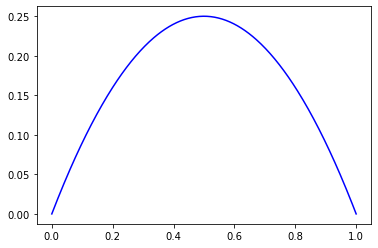

In [11]:
u = [0.] + list(u) + [0.]
u = asarray(u)
plot_field_1d(knots, p, u, nx=401)

### Exercise 1.

1. Implement a 1D Poisson solver using non homogeneous Dirichlet boundary conditions.

2. Implement a 2D Poisson solver using homogeneous and non homogeneous Dirichlet boundary conditions.

### Exercise 2.

We consider the Heat equation in 1D

$$
\partial_t u = \nabla^2 u
$$

with homogeneous boundary conditions.

1. Write an explicit FEM solver. What do you notice about the dependency of the CFL with respect to the degree? what about the regularity?

2. Write an implicit FEM solver.

### Exercise 3.

We consider a unidirectional flow in the velocity/pressure formulation

$$
\partial u_x = - \frac{1}{\rho} \partial_x p + \nu \partial_{yy}^2 u_x + g_x
$$

where the unknown $u_x$ is a function of $y$ only. 

We will consider $\partial_x p = -2$ and $g_x = 0.4$. The boundary conditions are given by $u_x(y=0) = u_x(y=h) = 0$.

1. Write an explicit and implicit time schemes and solvers.

2. Find numerical CFL in the case of explicit time scheme.

3. Find the steady state.


In [12]:
# css style
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()